In [2]:
%matplotlib inline

In [85]:
import os
import pickle
from math import floor
from random import shuffle
from statistics import variance
from statistics import mean
import math

from itertools import chain
from itertools import product
from itertools import groupby
from operator import itemgetter

import pandas as pd
import numpy as np

from geopy.distance import vincenty
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score

In [73]:
with open('data_routes_pickle/routes_coord_cur', 'rb') as f:
    routes_coord_cur = pickle.load(f)

with open('data_routes_pickle/sim_matrix_sim_segments_1_mod23', 'rb') as f:
    sim_matrix = np.array(pickle.load(f))

with open('data_routes_pickle/dist_matrix', 'rb') as f:
    dist_matrix = np.array(pickle.load(f))

with open('data_routes_pickle/cluster_count_cur', 'rb') as f:
    cluster_count_cur = pickle.load(f)

with open('data_routes_pickle/idxs', 'rb') as f:
    idxs = pickle.load(f)

In [158]:
# algo = KMeans(n_clusters=cluster_count, random_state=42)
# algo = AgglomerativeClustering(n_clusters=cluster_count_cur)
algo = Birch(threshold=80, branching_factor=120, n_clusters=19)

idxs = algo.fit_predict(dist_matrix)

route_idxs_per_cluster = [[] for i in range(19)]
for r_i, c_i in enumerate(idxs):
    route_idxs_per_cluster[c_i].append(r_i)
    
print([len(routes) for routes in route_idxs_per_cluster])
print()

for idx in idxs:
    print(idx, end=' ')

[39, 43, 15, 21, 24, 24, 20, 7, 23, 63, 23, 14, 1, 27, 9, 22, 5, 5, 15]

8 10 2 13 0 3 8 7 16 9 9 1 5 3 18 5 18 1 3 8 11 10 13 9 1 14 15 4 8 9 11 4 14 8 9 14 1 10 5 5 8 6 10 9 9 10 6 3 15 4 10 18 3 2 0 4 0 9 8 9 0 2 15 4 5 15 6 0 9 9 17 10 16 13 1 7 13 13 4 10 8 3 9 2 3 6 9 8 9 9 18 9 9 18 9 8 1 6 4 1 4 0 13 11 5 0 8 15 0 18 0 6 13 0 3 1 1 18 1 17 6 4 3 9 15 1 0 13 7 5 8 4 10 4 17 1 15 2 0 11 9 1 9 2 8 9 0 5 9 3 1 9 13 9 9 13 10 4 4 9 9 9 0 1 1 13 4 6 6 6 2 11 4 0 13 9 9 1 6 1 10 15 9 9 9 4 13 0 15 9 3 1 2 1 8 0 5 10 8 1 6 14 10 9 9 10 18 5 5 5 10 1 0 14 3 2 17 6 9 0 0 18 9 0 13 3 9 3 1 9 9 15 0 1 13 18 8 2 15 10 13 13 10 8 5 1 1 14 6 6 6 9 1 18 7 10 1 4 18 0 2 1 13 1 0 1 10 9 15 9 7 13 16 8 1 9 5 9 0 13 2 15 1 14 13 5 4 5 7 13 9 5 9 10 5 3 0 15 1 0 9 4 5 18 18 15 2 1 1 0 16 7 0 6 0 1 0 3 9 9 14 11 3 8 0 9 1 5 4 5 15 1 11 9 11 2 11 9 5 13 0 0 5 8 4 0 17 15 16 9 12 0 15 11 9 3 10 9 9 1 6 14 4 1 9 2 3 15 13 15 8 8 1 3 13 3 9 0 6 13 6 18 15 9 13 1 10 11 15 11 11 0 11 9 0 10 5 8 4 4 

In [143]:
def clustroid_idxs_per_cluster(route_idxs_per_cluster):
    clustroid_idxs = []
    rowsums = []
    for route_idxs in route_idxs_per_cluster:
        clustroid_idx = route_idxs[0]
        rowsum_min = rowsum(route_idxs, route_idxs[0])
        for route_idx in route_idxs[1:]:
            rowsum_cur = rowsum(route_idxs, route_idx)
            if rowsum_cur < rowsum_min:
                rowsum_min = rowsum_cur
                clustroid_idx = route_idx
        
        clustroid_idxs.append(clustroid_idx)
    
    return clustroid_idxs

In [136]:
def rowsum(cluster_route_idxs, route_idx):
    return sum([dist_matrix[route_idx][i] ** 2 for i in cluster_route_idxs])

In [195]:
def radiuses_per_cluster(route_idxs_per_cluster):
    clustroid_idxs = clustroid_idxs_per_cluster(route_idxs_per_cluster)
    return [mean([dist_matrix[clustroid_idxs[i]][j] ** 2 for j in cluster])
            for i, cluster in enumerate(route_idxs_per_cluster)]            

In [140]:
def diameters_per_cluster(route_idxs_per_cluster):
    return [math.sqrt(sum([rowsum(cluster, x) for x in cluster]) / (len(cluster) * (len(cluster) - 1)))
            if len(cluster) > 1 else 0 for cluster in route_idxs_per_cluster]

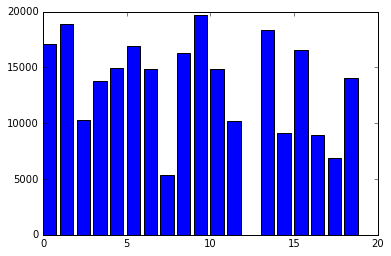

In [159]:
def rowsums_per_cluster(route_idxs_per_cluster):
    clustroid_idxs = clustroid_idxs_per_cluster(route_idxs_per_cluster)
    return [rowsum(route_idxs, clustroid_idxs[i]) for i, route_idxs in enumerate(route_idxs_per_cluster)]

rowsums = radiuses_per_cluster(route_idxs_per_cluster)
plt.bar(list(range(len(rowsums))), rowsums)
plt.show()

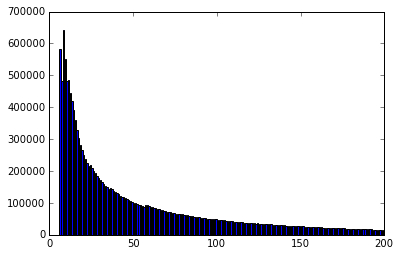

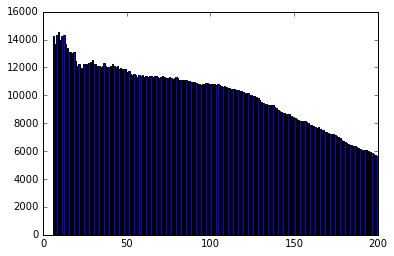

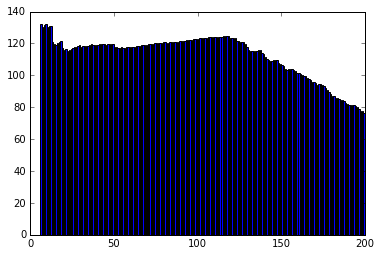

In [196]:
rowsums_avg, rads_avg, diams_avg = [], [], []
cluster_rount_range = range(6, 200)
for cluster_count in cluster_rount_range:
#     algo = KMeans(n_clusters=cluster_count, random_state=107)
    algo = AgglomerativeClustering(n_clusters=cluster_count)
#     algo = Birch(threshold=89, branching_factor=20, n_clusters=cluster_count)

    idxs = algo.fit_predict(dist_matrix)
    
    route_idxs_per_cluster = [[] for i in range(cluster_count)]
    for r_i, c_i in enumerate(idxs):
        route_idxs_per_cluster[c_i].append(r_i)
    
    rowsums = rowsums_per_cluster(route_idxs_per_cluster)
    rads = radiuses_per_cluster(route_idxs_per_cluster)
    diams = diameters_per_cluster(route_idxs_per_cluster)

    rowsums.remove(max(rowsums))
    
    rowsums_avg.append(mean(rowsums))
    rads_avg.append(mean(rads))
    diams_avg.append(mean(diams))

plt.bar(cluster_rount_range, rowsums_avg)
plt.show()
plt.bar(cluster_rount_range, rads_avg)
plt.show()
plt.bar(cluster_rount_range, diams_avg)
plt.show()